[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MDIL-SNU/sevennet_tutorial/blob/main/CMSS_DFT_2025/Part2_Fine_tuning/answer/2_Fine_tuning_answer.ipynb)

#Installation

SevenNet can be easily installed via pip.

In [1]:
!pip install sevenn==0.11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
Reason for being yanked: sevenn command fault
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.0/448.0 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.8/448.8 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.7 MB/s eta 0:00:00
  

Check whether your installation is successful

In [1]:
from sevenn.logger import Logger
logger = Logger(screen=True)
logger.greeting()

SevenNet: Scalable EquiVariance-Enabled Neural Network
version 0.11.2, Thu Jun 26 05:12:37 2025

                ****
              ********                                   .
              *//////,  ..                               .            ,*.
               ,,***.         ..                        ,          ********.                                  ./,
             .      .                ..   /////.       .,       . */////////                               /////////.
        .&@&/        .                  .(((((((..     /           *//////*.  ...                         *((((((((((.
     @@@@@@@@@@*    @@@@@@@@@@  @@@@@    *((@@@@@     (     %@@@@@@@@@@  .@@@@@@     ..@@@@.   @@@@@@*    .(@@@@@(((*
    @@@@@.          @@@@         @@@@@ .   @@@@@      #     %@@@@         @@@@@@@@     @@@@(,  @@@@@@@@.    @@@@@(*.
    %@@@@@@@&       @@@@@@@@@@    @@@@@   @@@@@      #  ., .%@@@@@@@@@    @@@@@@@@@@   @@@@,   @@@@@@@@@@   @@@@@
    ,(%@@@@@@@@@    @@@@@@@@@@     @@@@@ @@@@&   

# Obtain files from github

In [2]:
!git clone https://github.com/Jaesun0912/sevennet_tutorial.git

prefix = 'sevennet_tutorial/CMSS_DFT_2025/'

fatal: destination path 'sevennet_tutorial' already exists and is not an empty directory.


Confirm mounting and directories are successful

In [3]:
from ase.io import read
from ase.visualize import view
atoms = read(f'{prefix}/data/600K.extxyz')
view(atoms, viewer='x3d')

#1. Fine-tuning w/o shift adjustment

First, let's build model from checkpoint.

Unlike training from scratch, model weights are read from the values contained in the checkpoint.

In [4]:
import sevenn.util as util


model, config = util.model_from_checkpoint(f'{prefix}/pretrained/checkpoint_small.pth')

Next, let's load the dataset.

In this case, we will use only 1/4 of the total training set.

In [5]:
from torch_geometric.loader import DataLoader

from sevenn.train.graph_dataset import SevenNetGraphDataset


data_paths = [f'{prefix}/data/600K.extxyz', f'{prefix}/data/1200K.extxyz']
dataset = SevenNetGraphDataset(
    cutoff=config['cutoff'], files=data_paths, drop_info=False
)
num_dataset = len(dataset)
num_train = int(num_dataset * 0.25)
num_valid = 10

dataset = dataset.shuffle()
trainset = dataset[:num_train]
validset = dataset[num_train:num_train + 10]

train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
valid_loader = DataLoader(validset, batch_size=4)

Processing...
run_stat: 100%|██████████| 170/170 [00:00<00:00, 1527.51it/s]


Dataset is saved: ./sevenn_data/graph.pt


Done!


Here, we define hyperparameters for the fine-tuning.

In [6]:
from copy import deepcopy
import torch.optim.lr_scheduler as scheduler

from sevenn.error_recorder import ErrorRecorder
from sevenn.train.trainer import Trainer


config.update({
    'optimizer': 'adam',
    'optim_param': {'lr': 0.004},
    'scheduler': 'linearlr',
    'scheduler_param': {
        'start_factor': 1.0, 'total_iters': 10, 'end_factor': 0.0001
    },
    'is_ddp': False,  # 7net-0 is traied with ddp=True.
                      # We override this key False as we won't use it
    'loss': 'huber',
    'loss_param': {'delta': 0.01},
    'force_loss_weight': 0.1,
    'stress_loss_weight': 0.01,
})
trainer = Trainer.from_config(model, config)

train_recorder = ErrorRecorder.from_config(config)
valid_recorder = deepcopy(train_recorder)

Following script will fine-tune SevenNet-0-small with small epoch.

After training, we can save fine-tuned model to the checkpoint.

In [7]:
import os

import torch

from sevenn.logger import Logger


valid_best = float('inf')
total_epoch = 10

# As error recorder is long, let's use sevennet_logger for pretty print
# It is similar to outputs when using sevennet with terminal.
with Logger(filename='log.sevenn', screen=True) as logger:
  logger.greeting()  # prints ascii logo
  for epoch in range(total_epoch):
    logger.timer_start('epoch')
    # trainer scans whole data from given loader,
    # and updates error recorder with outputs.
    trainer.run_one_epoch(
        train_loader, is_train=True, error_recorder=train_recorder
    )
    trainer.run_one_epoch(
        valid_loader, is_train=False, error_recorder=valid_recorder
    )
    trainer.scheduler_step()
    train_err = train_recorder.epoch_forward()  # return averaged error & reset
    valid_err = valid_recorder.epoch_forward()
    logger.bar()
    logger.writeline(
        f'Epoch {epoch+1}/{total_epoch}  Learning rate: {trainer.get_lr()}'
    )
    logger.write_full_table([train_err, valid_err], ['Train', 'Valid'])
    logger.timer_end('epoch', message=f'Epoch {epoch+1} elapsed')

trainer.write_checkpoint(
    f'{prefix}/checkpoint_fine_tuned.pth', config=config, epoch=total_epoch
)

torch.cuda.empty_cache()

SevenNet: Scalable EquiVariance-Enabled Neural Network
version 0.11.2, Thu Jun 26 05:13:29 2025

                ****
              ********                                   .
              *//////,  ..                               .            ,*.
               ,,***.         ..                        ,          ********.                                  ./,
             .      .                ..   /////.       .,       . */////////                               /////////.
        .&@&/        .                  .(((((((..     /           *//////*.  ...                         *((((((((((.
     @@@@@@@@@@*    @@@@@@@@@@  @@@@@    *((@@@@@     (     %@@@@@@@@@@  .@@@@@@     ..@@@@.   @@@@@@*    .(@@@@@(((*
    @@@@@.          @@@@         @@@@@ .   @@@@@      #     %@@@@         @@@@@@@@     @@@@(,  @@@@@@@@.    @@@@@(*.
    %@@@@@@@&       @@@@@@@@@@    @@@@@   @@@@@      #  ., .%@@@@@@@@@    @@@@@@@@@@   @@@@,   @@@@@@@@@@   @@@@@
    ,(%@@@@@@@@@    @@@@@@@@@@     @@@@@ @@@@&   

#2. Fine-tuning w/ shift adjustment

In this case, let's adjust atomic energy reference that are adequate for the *ab initio* calculation settings / software that are used for calculating our fine-tuning database.

Following function `get_adjusted_shift` will run model from `cpt_path` on the database `data_paths`, and calculates proper (new) shift values

In [2]:
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
import torch
from torch_geometric.loader import DataLoader

import sevenn.train.atoms_dataset as ad
import sevenn.util as util


def _linregress_while_converge(
    total_energy_list, atomic_energy_list, atom_type_list, scale
):
    TOL = 1e-2
    MAX_ITER = 1000

    device = total_energy_list.device
    reg_model = LinearRegression(fit_intercept=False)
    contained_atom_types = atom_type_list.sum(dim=0) != 0
    shift = torch.zeros(atom_type_list.shape[-1], device=device)
    total_energy_list -= (scale * atomic_energy_list).sum(dim=1, keepdim=True)
    for _ in range(MAX_ITER):
        residual = \
            total_energy_list - (atom_type_list*shift).sum(dim=1, keepdim=True)
        result = \
            reg_model.fit(atom_type_list.cpu().numpy(), residual.cpu().numpy())
        delta = torch.tensor(result.coef_, device=device)[0]
        delta[~contained_atom_types] = 0.
        shift += delta
        if torch.abs(delta).max() < TOL:
            break

    return shift


def get_adjusted_shift(cpt_path, data_paths):
    try:
        model, config = util.model_from_checkpoint(cpt_path)
    except:  # alias of pre-trained model (e.g. 7net-0)
        cpt_path = util.pretrained_name_to_path(cpt_path)
        model, config = util.model_from_checkpoint(cpt_path)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    del model.force_output
    del model.rescale_atomic_energy, model.reduce_total_enegy
    scale = torch.tensor(config['scale'], device=device)
    model.eval()
    model = model.to(device)

    dataset = ad.SevenNetAtomsDataset(
        cutoff=config['cutoff'],
        files=data_paths
    )
    loader = DataLoader(dataset=dataset, batch_size=4, shuffle=False)

    total_energy_list, atomic_energy_list, atom_type_list = [], [], []
    total_species = len(config['_type_map'])

    with torch.no_grad():
        for batch in tqdm(loader):
            batch = batch.to(device, non_blocking=True)
            output = model(batch)

            total_energy = output.total_energy.detach()
            atom_type = output.atom_type.detach()
            atomic_energy = output.scaled_atomic_energy.detach()
            indices = batch.num_atoms.tolist()
            total_ens = torch.unbind(total_energy)
            atomic_energy = torch.split(atomic_energy.squeeze(-1), indices)
            atom_types = torch.split(atom_type, indices)

            for total_en, atomic_en, atom_type in zip(
                total_ens, atomic_energy, atom_types
            ):
                total_energy_list.append(total_en)
                atomic_en = torch.zeros(
                    total_species,
                    dtype=atomic_en.dtype,
                    device=atomic_en.device,
                ).scatter_reduce(
                    0,
                    atom_type,
                    atomic_en,
                    reduce='sum'
                )
                atomic_energy_list.append(atomic_en)

                atom_type = torch.zeros(
                    total_species,
                    dtype=torch.long,
                    device=atom_type.device
                ).scatter_reduce(
                    0,
                    atom_type,
                    torch.ones(
                        atom_type.numel(),
                        dtype=torch.long,
                        device=atom_type.device
                    ),
                    reduce='sum'
                )
                atom_type_list.append(atom_type)
    del model
    torch.cuda.empty_cache()
    total_energy_list = torch.vstack(total_energy_list)
    atomic_energy_list = torch.vstack(atomic_energy_list)
    atom_type_list = torch.vstack(atom_type_list)

    return _linregress_while_converge(
        total_energy_list, atomic_energy_list, atom_type_list, scale
    )

First, let's load the database (same with the case 1.)

In [3]:
from torch_geometric.loader import DataLoader

from sevenn.train.graph_dataset import SevenNetGraphDataset
import sevenn.util as util

_, config = util.model_from_checkpoint(f'{prefix}/pretrained/checkpoint_small.pth')

data_paths = [f'{prefix}/data/600K.extxyz', f'{prefix}/data/1200K.extxyz']
dataset = SevenNetGraphDataset(
    cutoff=config['cutoff'], files=data_paths, drop_info=False
)
num_dataset = len(dataset)
num_train = int(num_dataset * 0.25)
num_valid = 10

dataset = dataset.shuffle()
trainset = dataset[:num_train]
validset = dataset[num_train:num_train + 10]

train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
valid_loader = DataLoader(validset, batch_size=4)

Run `get_adjusted_shift` to get proper shift values

In [4]:
shift = get_adjusted_shift(
    f'{prefix}/pretrained/checkpoint_small.pth', data_paths
).tolist()

100%|██████████| 43/43 [00:05<00:00,  8.13it/s]


Load model from checkpoint.

In this case, we change the shift value of the `rescale_atomic_energy` block to the proper value.

Also, we may set shift and scale value trainable, which additionally help models to find proper shift values.

In [6]:
import sevenn.util as util
from sevenn.nn.scale import SpeciesWiseRescale

model, config = util.model_from_checkpoint(
    f'{prefix}/pretrained/checkpoint_small.pth'
  )

# To enhance training speed, we will overwrite shift scale module to trainable
# By making energy shift trainable, error quickly converges.
shift_scale_module = model._modules['rescale_atomic_energy']
scale = shift_scale_module.scale.tolist()

model._modules['rescale_atomic_energy'] = SpeciesWiseRescale(
    shift=shift,
    scale=scale,
    train_shift_scale=True,
)

Setting hyperparameters for the fine-tuning.

Before we starts, let's save the initial checkpoint, which only changes shift values of the SevenNet-0-small.

This checkpoint will not change underlying physics, but changes absolute energy values to the proper range.

In [7]:
from copy import deepcopy
import torch.optim.lr_scheduler as scheduler

from sevenn.error_recorder import ErrorRecorder
from sevenn.train.trainer import Trainer


config.update({
    'optimizer': 'adam',
    'optim_param': {'lr': 0.004},
    'scheduler': 'linearlr',
    'scheduler_param': {
        'start_factor': 1.0, 'total_iters': 10, 'end_factor': 0.0001
    },
    'is_ddp': False,  # 7net-0 is traied with ddp=True.
                      # We override this key False as we won't use it
    'loss': 'huber',
    'loss_param': {'delta': 0.01},
    'force_loss_weight': 0.1,
    'stress_loss_weight': 0.01,
})
trainer = Trainer.from_config(model, config)
trainer.write_checkpoint(
    f'{prefix}/checkpoint_shift.pth', config=config, epoch=0
)

train_recorder = ErrorRecorder.from_config(config)
valid_recorder = deepcopy(train_recorder)

The same scripts for the training.

In [8]:
import os

import torch

from sevenn.logger import Logger


valid_best = float('inf')
total_epoch = 10

# As error recorder is long, let's use sevennet_logger for pretty print
# It is similar to outputs when using sevennet with terminal.
with Logger(filename='log.sevenn', screen=True) as logger:
  logger.greeting()  # prints ascii logo
  for epoch in range(total_epoch):
    logger.timer_start('epoch')
    # trainer scans whole data from given loader,
    # and updates error recorder with outputs.
    trainer.run_one_epoch(
        train_loader, is_train=True, error_recorder=train_recorder
    )
    trainer.run_one_epoch(
        valid_loader, is_train=False, error_recorder=valid_recorder
    )
    trainer.scheduler_step()
    train_err = train_recorder.epoch_forward()  # return averaged error & reset
    valid_err = valid_recorder.epoch_forward()
    logger.bar()
    logger.writeline(
        f'Epoch {epoch+1}/{total_epoch}  Learning rate: {trainer.get_lr()}'
    )
    logger.write_full_table([train_err, valid_err], ['Train', 'Valid'])
    logger.timer_end('epoch', message=f'Epoch {epoch+1} elapsed')

trainer.write_checkpoint(
    f'{prefix}/checkpoint_fine_tuned_shift.pth',
    config=config,
    epoch=total_epoch
)

torch.cuda.empty_cache()

SevenNet: Scalable EquiVariance-Enabled Neural Network
version 0.11.2, Thu Jun 26 05:17:31 2025

                ****
              ********                                   .
              *//////,  ..                               .            ,*.
               ,,***.         ..                        ,          ********.                                  ./,
             .      .                ..   /////.       .,       . */////////                               /////////.
        .&@&/        .                  .(((((((..     /           *//////*.  ...                         *((((((((((.
     @@@@@@@@@@*    @@@@@@@@@@  @@@@@    *((@@@@@     (     %@@@@@@@@@@  .@@@@@@     ..@@@@.   @@@@@@*    .(@@@@@(((*
    @@@@@.          @@@@         @@@@@ .   @@@@@      #     %@@@@         @@@@@@@@     @@@@(,  @@@@@@@@.    @@@@@(*.
    %@@@@@@@&       @@@@@@@@@@    @@@@@   @@@@@      #  ., .%@@@@@@@@@    @@@@@@@@@@   @@@@,   @@@@@@@@@@   @@@@@
    ,(%@@@@@@@@@    @@@@@@@@@@     @@@@@ @@@@&   

#3. Application 1: Single-point calculation

`ASE` provides simulation interface for MLIPs using `Calculator` object in python.

Many MLIP packages provides custom `Calculator` objects, including SevenNet

SevenNet calculator can be obtained by followings:

```
from sevenn.calculator import SevenNetCalculator
calc = SevenNetCalculator({checkpoint_path})
...
```

for `checkpoint_path`, one should provide
- Path / file name of generated checkpoint.pth file
- Name of pretrained models (e.g., 7net-0)

Further details using `Calculator` object can be found in `ASE` documentation

(https://wiki.fysik.dtu.dk/ase/gettingstarted/tut01_molecule/molecule.html)

In this example, let's calculate energy, force, stress of *ab initio* MD simulation trajectories of another supercell, and compare the accuracy with respect to the DFT.

We have total 4 models.

- 7net-0-small: Pretrained SevenNet
- 7net-0-shift: 7net-0-small with adjusted shift
- 7net-FT: Fine-tuned model from 7net-0-small
- 7net-FT-shift: Fine-tuned model from 7net-0-shift

In [3]:
import numpy as np
from tqdm import tqdm
from ase.io import read
from ase.units import bar

from sevenn.calculator import SevenNetCalculator

labels = ['7net-0-small', '7net-0-shift', '7net-FT', '7net-FT-shift']

dft_energy, dft_forces, dft_stress = [], [], []
mlip_energy_dct = {label: [] for label in labels}
mlip_forces_dct = {label: [] for label in labels}
mlip_stress_dct = {label: [] for label in labels}
to_kBar = 1/bar/1000

label_cpt_path_map = {
    '7net-0-small': f'{prefix}/pretrained/checkpoint_small.pth',
    '7net-0-shift': f'{prefix}/checkpoint_shift.pth',
    '7net-FT': f'{prefix}/checkpoint_fine_tuned.pth',
    '7net-FT-shift': f'{prefix}/checkpoint_fine_tuned_shift.pth',
}

traj = read(f'{prefix}/data/test_md.extxyz', ':')
for atoms in tqdm(traj, desc='DFT'):
    dft_energy.append(atoms.get_potential_energy() / len(atoms))
    dft_forces.extend(atoms.get_forces().flatten())
    dft_stress.extend(atoms.get_stress().flatten() * to_kBar)

for label in labels:
    calc = SevenNetCalculator(label_cpt_path_map[label])
    for atoms in tqdm(traj, desc=label):
        atoms.calc = calc
        mlip_energy_dct[label].append(atoms.get_potential_energy() / len(atoms))
        mlip_forces_dct[label].extend(atoms.get_forces().flatten())
        mlip_stress_dct[label].extend(atoms.get_stress().flatten() * to_kBar)
        atoms.calc = None
    del calc

7net-FT-shift: 100%|██████████| 200/200 [00:16<00:00, 12.50it/s]


Let's plot the correlation between DFT and each model on the single-point calculated energy, force, and stress.

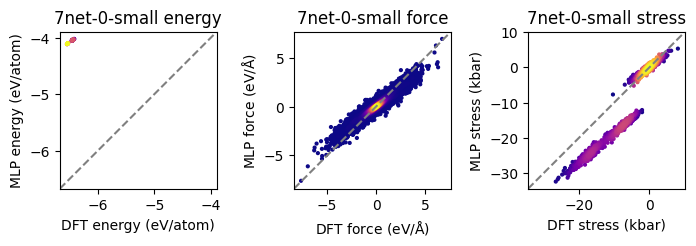

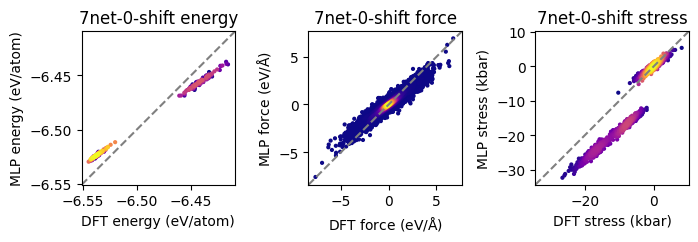

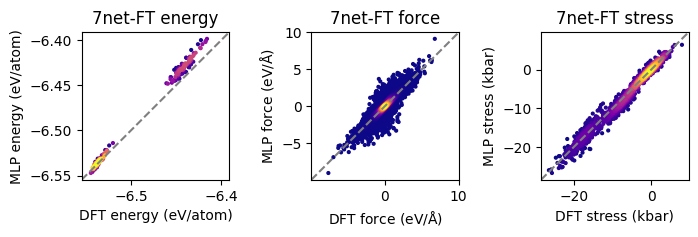

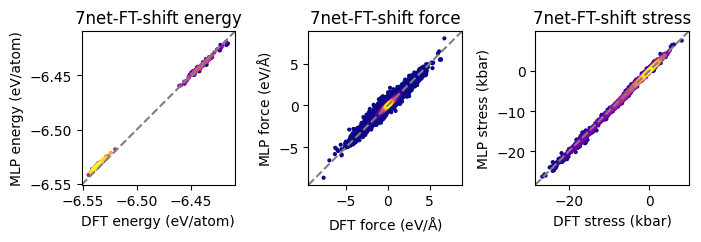

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# draw a parity plot of energy / force / stress
unit = {"energy": "eV/atom", "force": r"eV/$\rm{\AA}$", "stress": "kbar"}
def density_colored_scatter_plot(
    dft_energy,
    nnp_energy,
    dft_force,
    nnp_force,
    dft_stress,
    nnp_stress,
    title=None
):
    modes = ['energy', 'force', 'stress']
    plt.figure(figsize=(18/2.54, 6/2.54))
    for num, (x, y) in enumerate(
        zip(
            [dft_energy, dft_force, dft_stress],
            [nnp_energy, nnp_force, nnp_stress]
        )
    ):
        mode = modes[num]
        idx = (
            np.random.choice(len(x), 1000)
            if len(x) > 1000
            else list(range(len(x)))
        )
        xsam = [x[i] for i in idx]
        ysam = [y[i] for i in idx]
        xy = np.vstack([x, y])
        xysam = np.vstack([xsam, ysam])
        zsam = gaussian_kde(xysam)

        z = zsam.pdf(xy)
        idx = z.argsort()

        x = [x[i] for i in idx]
        y = [y[i] for i in idx]
        z = [z[i] for i in idx]

        ax = plt.subplot(int(f'13{num+1}'))
        plt.scatter(x, y, c=z, s=4, cmap='plasma')

        mini = min(min(x), min(y))
        maxi = max(max(x), max(y))
        ran = (maxi-mini) / 20
        plt.plot(
            [mini-ran, maxi+ran],
            [mini-ran, maxi+ran],
            color='grey',
            linestyle='dashed'
        )
        plt.xlim(mini-ran, maxi+ran)
        plt.ylim(mini-ran, maxi+ran)

        plt.xlabel(f'DFT {mode} ({unit[mode]})')
        plt.ylabel(f'MLP {mode} ({unit[mode]})')
        ax.set_aspect('equal')
        if title:
          ax.set_title(f'{title} {mode}')
    plt.tight_layout()
    plt.show()

for label in labels:
    density_colored_scatter_plot(
        dft_energy,
        mlip_energy_dct[label],
        dft_forces,
        mlip_forces_dct[label],
        dft_stress,
        mlip_stress_dct[label],
        label,
    )

#Application 2: Geometric relaxation

From now on, we will utilize 7net-FT-shift as a base model.

Geometric relaxation is a task that finds the local energy minimum at given potential energy surface (PES) near the initial configuration.

This can be done by using ASE modules, combining `Optimizer`, `Filter` and `Calculator` object.

- `Optimizer` gives the algorithm for energy minimization
- `Filter` gives more advanced feature of relaxation (e.g, relax both atomic position and cell size, ISIF=3 in VASP)
- `Calculator` gives PES, just like described in Appl. 1.

For more information, please check:

https://wiki.fysik.dtu.dk/ase/ase/optimize.html

https://wiki.fysik.dtu.dk/ase/ase/filters.html

First, let's call the SevenNetCalculator.

In [3]:
from sevenn.calculator import SevenNetCalculator


calc = SevenNetCalculator(f'{prefix}/checkpoint_fine_tuned_shift.pth')

Next, we can relax a Argyrodite supercell.

       Step     Time          Energy          fmax
LBFGS:    0 05:22:53    -2679.176025        6.558199
LBFGS:    1 05:22:55    -2686.825439        2.609045
LBFGS:    2 05:22:55    -2702.469971        3.214455
LBFGS:    3 05:22:56    -2709.358887        4.449128
LBFGS:    4 05:22:57    -2714.340088        4.086959
LBFGS:    5 05:22:57    -2718.036133        2.618556
LBFGS:    6 05:22:57    -2720.891602        1.589894
LBFGS:    7 05:22:57    -2723.697754        2.900627
LBFGS:    8 05:22:57    -2725.906738        5.053066
LBFGS:    9 05:22:58    -2728.836426        2.097962
LBFGS:   10 05:22:58    -2729.953369        1.479413
LBFGS:   11 05:22:58    -2731.487305        2.108941
LBFGS:   12 05:22:58    -2732.548340        2.658142
LBFGS:   13 05:22:58    -2733.972412        1.679611
LBFGS:   14 05:22:59    -2734.899170        1.202169
LBFGS:   15 05:23:00    -2735.845703        1.062781
LBFGS:   16 05:23:00    -2736.520020        1.647995
LBFGS:   17 05:23:00    -2737.198730        1.33

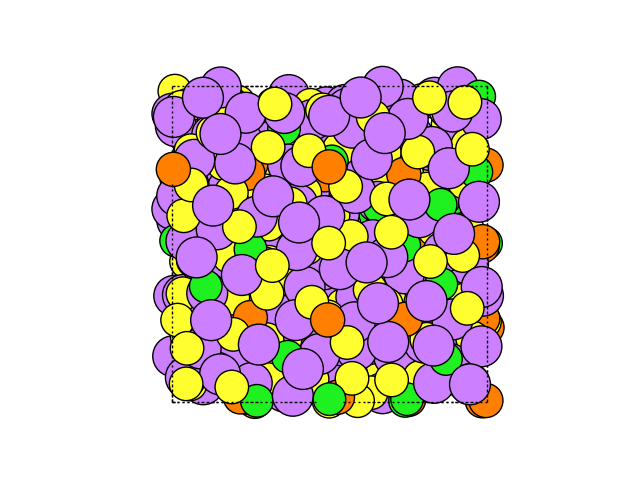

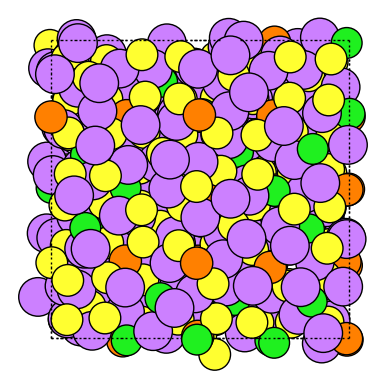

In [5]:
from IPython.display import Image

from ase.io import read, write, Trajectory
from ase.optimize import LBFGS  # Optimizer
from ase.filters import FrechetCellFilter  # Filter

atoms = read(f'{prefix}/data/test_md.extxyz', 0)
atoms.calc = calc

cf = FrechetCellFilter(atoms, hydrostatic_strain=True)
opt = LBFGS(cf, trajectory=f'{prefix}/relax.traj')
opt.run(fmax=0.05, steps=1000)

traj = Trajectory(f'{prefix}/relax.traj')
possible = []
for i in range(len(traj)):
    try:
        possible.append(traj[i])
    except:
        pass
write(f'{prefix}/relax.gif', possible[::10])
write(f'{prefix}/relax.extxyz', atoms)

vol = atoms.get_cell().volume / 8 # 222 supercell
print(f'Relaxed volume per unit cell = {vol} Å³')
print(f'Experimental volume per unit cell = 956 - 960 Å³')

Image(open(f'{prefix}/relax.gif', 'rb').read())

#Application 3: NVT MD simulation

From relaxed geometries, let's run MD simulation at constant temperature and volume.

In ASE, they provide various NVT ensembls, such as Langevin, Nose-Hoover, and etc.

For more information please follow:

https://wiki.fysik.dtu.dk/ase/ase/md.html

Here, we will run Langevin dynamics at 600 K.

While MD, let's check the diffusivity of each atoms.


In [6]:
from IPython.display import Image
import numpy as np

from ase.io import read
from ase import units
from ase.md import MDLogger
from ase.md.langevin import Langevin

from sevenn.calculator import SevenNetCalculator


calc = SevenNetCalculator(f'{prefix}/checkpoint_fine_tuned_shift.pth')
atoms = read(f'{prefix}/relax.extxyz')
atoms.calc = calc
atoms.set_momenta(
    np.random.normal(
        scale=np.sqrt(units.kB * 600 * atoms.get_masses()[:, None]),
        size=(len(atoms), 3)
    )
)
timestep = 2 * units.fs  # 1 femtosecond
friction = 0.01 / units.fs  # Friction coefficient
dyn = Langevin(
    atoms,
    timestep,
    trajectory=f'{prefix}/nvt_md.traj',
    temperature_K=600,
    friction=friction
)

logger = MDLogger(dyn, atoms, '-', header=True, stress=True, peratom=True)
dyn.attach(logger, interval=10)
dyn.run(1000)

Time[ps]    Etot/N[eV]   Epot/N[eV]   Ekin/N[eV]    T[K]      ---------------------- stress [GPa] -----------------------
0.0000          -6.5333      -6.6086       0.0753   582.5     -0.378     -0.392     -0.412     -0.015      0.037      0.062
0.0200          -6.5285      -6.5670       0.0385   297.9     -0.885     -0.650     -1.002     -0.095      0.247      0.101
0.0400          -6.5158      -6.5631       0.0474   366.4     -0.796     -0.682     -0.782     -0.199      0.044      0.203
0.0600          -6.5033      -6.5549       0.0516   399.0     -0.820     -1.076     -0.842      0.279      0.197      0.020
0.0800          -6.4926      -6.5487       0.0561   433.9     -0.904     -1.187     -1.088      0.100      0.030      0.261
0.1000          -6.4849      -6.5447       0.0598   462.7     -1.009     -0.799     -0.994     -0.026      0.106      0.147
0.1200          -6.4780      -6.5446       0.0666   514.9     -0.903     -0.743     -0.782     -0.008      0.460     -0.098
0.1400    

True

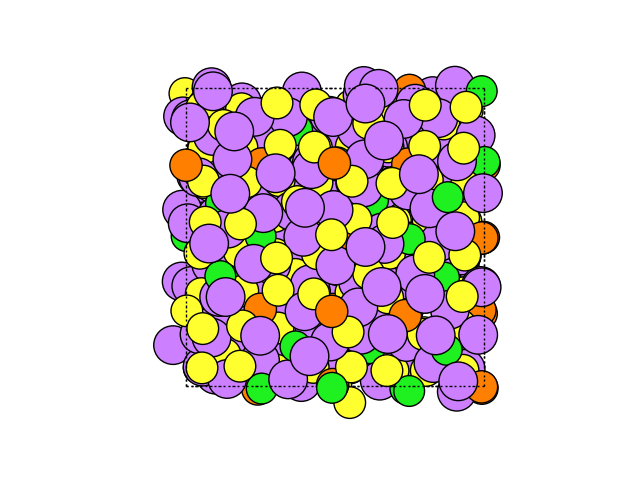

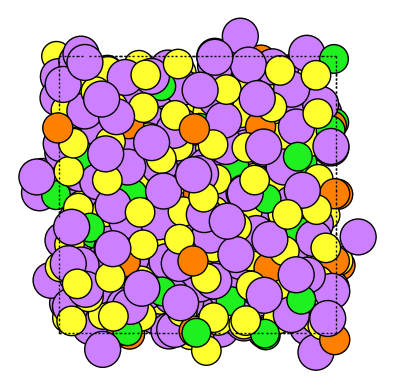

In [7]:
from ase.io import write, Trajectory


traj = Trajectory(f'{prefix}/nvt_md.traj')
possible = []
for i in range(len(traj)):
    try:
        possible.append(traj[i])
    except:
        pass
write(f'{prefix}/nvt_md.gif', possible[::50])

Image(open(f'{prefix}/nvt_md.gif', 'rb').read())

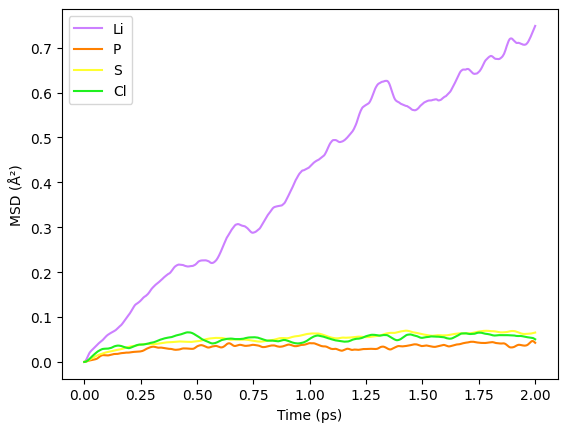

In [8]:
import matplotlib.pyplot as plt
from ase.io import write, Trajectory


traj = Trajectory(f'{prefix}/nvt_md.traj')
possible = []
for i in range(len(traj)):
    try:
        possible.append(traj[i])
    except:
        pass

init = possible[0]
init_pos = init.get_positions()
elem_types = np.array(init.get_chemical_symbols())

elems = ['Li', 'P', 'S', 'Cl']
msd = {elem: [0] for elem in elems}
time = [0]

for timestep, atoms in enumerate(possible):
    time.append(timestep*2/1000) # in ps
    for elem in elems:
        init = init_pos[elem_types==elem]
        pos = atoms.get_positions()[elem_types==elem]
        msd[elem].append(np.mean(np.square(init-pos)))

color = {
    'Li': (204/255, 128/255, 1),
    'P': (1, 128/255, 0),
    'S': (1, 1, 48/255),
    'Cl': (31/255, 240/255, 31/255),
}

plt.figure()
for elem in elems:
    plt.plot(time, msd[elem], color=color[elem], label=elem)

plt.legend()
plt.xlabel('Time (ps)')
plt.ylabel('MSD (Å²)')
plt.show()